# Uncertainty Quantification

## Overview
    we will analyze why we cannot get the right count for some transcripts using the output of salmon. 

## Analyze tools
    we will mainly use dataframe of pandas to analyze the data.

In [1]:
import tsv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

## root path

In [2]:
root_path = "../data/poly_mo/"

# data Preprocess

## Poly Truth
    Read the file poly_truth.tsv
    Poly_truth.tsv: true counts for each transcript

In [3]:
# Poly_truth.tsv: true counts for each transcript
poly_truth = open(root_path+"poly_truth.tsv")
lines = poly_truth.readlines()
poly_truth.close()
# print l
count = 0
poly_truth = []
for line in lines:
    line = line[:-1]
    l = line.split('\t')
    poly_truth.append(l)

df_poly_truth = pd.DataFrame.from_records(poly_truth[1:], columns=poly_truth[0])

In [4]:
df_poly_truth['transcript_id']=df_poly_truth['transcript_id'].astype(str)
df_poly_truth['count']=df_poly_truth['count'].astype(int)

In [5]:
df_poly_truth.describe()

,count
count,2.695900e+04
mean,1.483678e+03
std,1.504054e+04
min,1.000000e+00
25%,1.700000e+01
50%,1.420000e+02
75%,7.350000e+02
max,1.316896e+06


In [7]:
df_poly_truth.head(5)

,transcript_id,count
0,ENST00000608495,1
1,ENST00000382369,55
2,ENST00000360321,54
3,ENST00000400269,92
4,ENST00000382352,2653


In [5]:
truth_id = df_poly_truth.transcript_id

## Quant_bootstraps
    Read the file quant_bootstraps.tsv
    Quant_bootstraps.tsv :containing the matrix of bootstrap experiments containing the final count for each transcript in each round of bootstrapping with a row be a bootstrap output and columns be list of transcripts. 

In [6]:
# Quant_bootstraps.tsv :containing the matrix of bootstrap experiments 
# containing the final count for each transcript in each round of bootstrapping 
# with a row be a bootstrap output and columns be list of transcripts. 

quant_bootstraps = tsv.TsvReader(open(root_path+"quant_bootstraps.tsv"))
count = 0
quant_boot = []
for parts in quant_bootstraps:
    quant_boot.append(parts)
#     print len(parts)
print(len(quant_boot))

201


In [7]:
df_quant_boot = pd.DataFrame.from_records(quant_boot[1:], columns=quant_boot[0])
# print(len(quant_boot[1,:]))

In [12]:
df_quant_boot.describe()

,ENST00000382410,ENST00000382398,ENST00000382388,ENST00000334391,ENST00000246105,ENST00000382376,ENST00000608495,ENST00000382369,ENST00000360321,ENST00000400269,...,ENST00000361739,ENST00000361851,ENST00000361899,ENST00000362079,ENST00000361227,ENST00000361335,ENST00000361381,ENST00000361567,ENST00000361681,ENST00000361789
count,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
unique,1,1,1,1,1,1,1,200,200,200,...,190,148,187,187,172,165,191,180,185,187
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.137669328,17.2697468599,61.2402575227,...,340011.0,8220.0,226020.0,350241.0,30662.0,22438.0,415926.0,210106.0,72774.0,155444.0
freq,200,200,200,200,200,200,200,1,1,1,...,3,4,2,2,3,3,2,3,2,3


In [8]:
id_qb = list(df_quant_boot.columns)

### Sort the quant_boot Results
#### Attention: there are some ids in truth_id but not in quant_boot

In [9]:
sort_qb = []
use_id = []
for id in truth_id:
    try:
        listed = list(df_quant_boot[id])        
    except KeyError:
#         print('has No '+id) # there are some ids in truth_id but not in quant_boot
        pass
    else:
        use_id.append(id)
        listed.sort()
        sort_qb.append(listed)

### reverse sort_qb

In [10]:
sort_qb = list(map(list,zip(*sort_qb)))

### transfer to dataframe

In [11]:
df_qb_sorted = pd.DataFrame.from_records(sort_qb, columns=use_id)

## Filter the False

### find the value of 2.5% & 97.5% and the false transcript is out of this range

In [12]:
df_poly_truth = df_poly_truth.set_index(['transcript_id'])

In [13]:
sum = len(sort_qb)
print(int(sum*0.025))
print(int(sum*0.975))
percent2dot5 = df_qb_sorted.loc[int(sum*0.025)-1]
percent97dot5 = df_qb_sorted.loc[int(sum*0.975)-1]

5
195


## divide the transcript_id into two group
    if the true_count of the id is in the range(2.5%,97.5%)，we will set it in the true_id group.
    if the true_coutn of the id is out of the range(2.5%,97.5%), we set it in the false_id group.

In [14]:
true_id = []
false_id = []
for id in use_id:
    down = float(percent2dot5[id])
    up = float(percent97dot5[id])
    true_count = df_poly_truth.loc[id]
    true_count = float(true_count)
    if true_count>down and true_count<up:
        true_id.append(id)
    else:
        false_id.append(id)

### concatenate the true and false id
    we put the true_id and false_id in the same list in sequence, and then we will add label for them.

In [15]:
# concatenate the true and false id in one list
all_id = list(true_id)
all_id.extend(false_id)

### add label for the list
    set label for every transcript_id(success(true_id,set as 1),fail(false_id,set as 0))
    And them we will merge this labeled list with list of properties in order to get a list which include both properties and label of every transcript.

In [16]:
# add label for the id
label = []
for i in range(len(true_id)):
    label.append(1)
for i in range(len(false_id)):
    label.append(0)
    
labeled_id = [all_id,label]
labeled = list(map(list,zip(*labeled_id)))

## Read Quant.sf
    Read the quant.sf file.
    Quant.sf :estimated quantifications for each transcript

In [17]:
# Quant.sf :estimated quantifications for each transcript
quant_file = open(root_path+"quant.sf")
lines = quant_file.readlines()
quant_file.close()
count = 0
quant = []
for line in lines:
    line = line[:-1]
    l = line.split('\t')
    quant.append(l)

In [18]:
df_quant = pd.DataFrame.from_records(quant[1:], columns=quant[0])

In [19]:
df_quant.Name = df_quant.Name.astype(str)
df_quant.Length = df_quant.Length.astype(int)
df_quant.EffectiveLength = df_quant.EffectiveLength.astype(float)
df_quant.TPM = df_quant.TPM.astype(float)
df_quant.NumReads = df_quant.NumReads.astype(float)

## Merge quant.sf and labeled_id to get the useful data for training
    labeled_id is a list of transcript_id togather with label(success(true，set as 1) or fail(flase,set as 0))  
    And we will add the label with the protery from quant.sf in order to analyze the properties of different label.
    Then it will be easy for us to analyze the relation between properties and label and the difference between group of different label.

#### merge the data

In [20]:
df_labeled_id = pd.DataFrame.from_records(labeled, columns=['Name','label'])
df_labeled_id.Name = df_labeled_id.Name.astype(str)
df_labeled = df_labeled_id.merge(df_quant, on='Name')

#### put label as the last property

In [21]:
label = df_labeled.pop('label')
df_labeled.insert(5,'label',label)

#### set "data = df_labeled" for easy processing the data below 

In [22]:
data = df_labeled

## Analyze the difference between true & false data

### we can easily found that some Stastistic value like mean,min,max,std of TPM & NumReads has great difference between false and true

In [23]:
data.groupby([data.label]).mean()

,Length,EffectiveLength,TPM,NumReads
label,,,,
0,2445.007350,2245.894343,52.556885,1784.370671
1,2018.732216,1819.722173,6.678858,152.544354


In [24]:
data.groupby([data.label]).max()

,Name,Length,EffectiveLength,TPM,NumReads
label,,,,,
0,ENST00000610278,101518,101318.991,23356.420222,1.109005e+06
1,ENST00000610279,37027,36827.991,10710.459004,3.769085e+04


In [25]:
data.groupby([data.label]).min()

,Name,Length,EffectiveLength,TPM,NumReads
label,,,,,
0,ENST00000000233,158,10.987,0.0,0.0
1,ENST00000002165,82,9.804,0.0,0.0


In [28]:
data.groupby([data.label]).std()

,Length,EffectiveLength,TPM,NumReads
label,,,,
0,2380.728560,2380.669848,448.368497,15740.352178
1,2055.905694,2055.526264,45.873037,235.234059


In [26]:
data.describe()

,Length,EffectiveLength,TPM,NumReads,label
count,26889.000000,26889.000000,26889.000000,2.688900e+04,26889.000000
mean,2301.266912,2102.188625,37.086764,1.234117e+03,0.337201
std,2268.852362,2268.766111,373.615192,1.284316e+04,0.472763
min,82.000000,9.804000,0.000000,0.000000e+00,0.000000
25%,777.000000,577.998000,0.359912,1.304699e+01,0.000000
50%,1681.000000,1481.991000,2.837799,1.174560e+02,0.000000
75%,3016.000000,2816.991000,12.063695,5.993793e+02,1.000000
max,101518.000000,101318.991000,23356.420222,1.109005e+06,1.000000


## Visualization
    we will show the label data with NumReads and TPM as axis

In [27]:
true_data = data[data.label==1]
false_data = data[(data.label==0)]
# true_data = data[(data.label==1)&(data.TPM<8000)&(data.NumReads<300000)]
# false_data = data[(data.label==0)&(data.TPM<8000)&(data.NumReads<300000)]

In [28]:
TPM_true = true_data.TPM
NumReads_true = true_data.NumReads
TPM_false = false_data.TPM
NumReads_false = false_data.NumReads

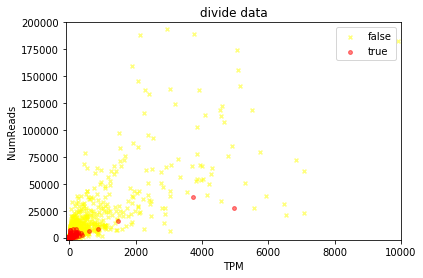

In [29]:
divide_data = plt.figure(1)  
plt.scatter(TPM_false,NumReads_false,marker='x',color='yellow',label='false',s=15,alpha=0.5)
plt.scatter(TPM_true,NumReads_true,marker='o',color='red',label='true',s=15,alpha=0.5)
plt.xlim((-100, 10000))
plt.ylim((-2000, 200000))
plt.legend() # 展示图例
plt.xlabel('TPM') # 给 x 轴添加标签
plt.ylabel('NumReads') # 给 y 轴添加标签
plt.title('divide data') # 添加图形标题
plt.show()

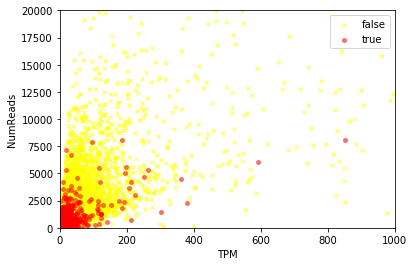

In [30]:
miniscale = plt.figure(2)
plt.xlim((0, 1000))
plt.ylim((0, 20000))
plt.scatter(TPM_false,NumReads_false,marker='x',color='yellow',label='false',s=15,alpha=0.5)
plt.scatter(TPM_true,NumReads_true,marker='o',color='red',label='true',s=15,alpha=0.5)
plt.legend() # 展示图例
plt.xlabel('TPM') # 给 x 轴添加标签
plt.ylabel('NumReads') # 给 y 轴添加标签
plt.show()

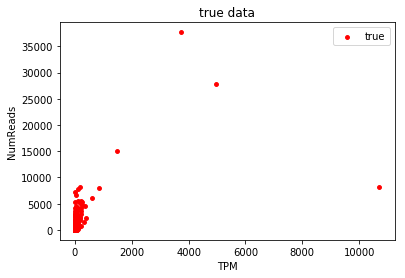

In [31]:
true_data = plt.figure(3)  
plt.scatter(TPM_true,NumReads_true,color='red',label='true',s=15,alpha=1)
plt.legend() # 展示图例
plt.xlabel('TPM') # 给 x 轴添加标签
plt.ylabel('NumReads') # 给 y 轴添加标签
plt.title('true data')
plt.show()

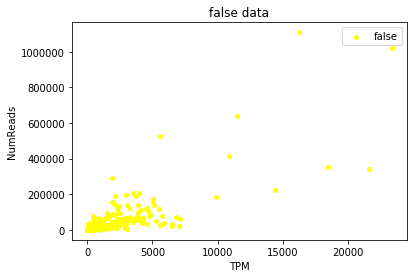

In [32]:
flase_data = plt.figure(4)
plt.scatter(TPM_false,NumReads_false,color='yellow',label='false',s=15,alpha=1)
plt.legend() # 展示图例
plt.xlabel('TPM') # 给 x 轴添加标签
plt.ylabel('NumReads') # 给 y 轴添加标签
plt.title('false data')
plt.show()

# Some Classification Models

In [33]:
data.head(5)

,Name,Length,EffectiveLength,TPM,NumReads,label
0,ENST00000382369,1420,1220.991,1.180968,46.855146,1
1,ENST00000360321,1575,1375.991,0.912080,40.780781,1
2,ENST00000460062,552,353.005,15.124547,173.488438,1
3,ENST00000608066,577,378.005,3.340497,41.031309,1
4,ENST00000246104,3577,3377.991,0.036441,4.000000,1


### prepare the training data

In [34]:
from sklearn.utils import shuffle  

#### Shuffle the data

In [35]:
sfdata = shuffle(data) # make the data random
input_data = sfdata[['Length','EffectiveLength','TPM','NumReads']]
input_label = sfdata['label']

In [36]:
train = int(len(input_data)*9/10)
test = train+1
train_data = input_data[0:train]
train_label = input_label[0:train]
test_data = input_data[test:]
test_label = input_label[test:]

In [37]:
def trans_onehot(labels):
    onehot_labels = []
    for label in labels:
        if label==0:
            onehot_labels.append([0,1])
        else:
            onehot_labels.append([1,0])
    return onehot_labels

In [38]:
train_onehot_label = trans_onehot(train_label)
test_onehot_label = trans_onehot(test_label)

In [39]:
def square(x):
    return x**2


def cal_mse(regr,test_label):
    error = (regr-test_label)
    error_sq = error.apply(square)
    mse = error_sq.sum()/len(error)
    return mse

def cal_pred(regr,alpha):
    pred=[]
    for x in regr:
        if x>=alpha:
            pred.append(1)
        else:
            pred.append(0)
    return pred

def cal_accuracy(pred,test_label):
    diff = pred-test_label
    diff=diff.as_matrix()
    diff = diff.tolist()
    right_count = diff.count(0)
#     print(right_count)
    accuracy = right_count/len(diff)
    return accuracy

### Nerual Network

#### with tensorflow

In [40]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [41]:
# Training Data
train_X = train_data.as_matrix()
train_Y = train_label.as_matrix()
train_X = np.reshape(train_X,(len(train_X),4))  
train_Y = np.reshape(train_Y,(len(train_Y),1))  
n_samples = train_X.shape[0]

In [386]:
# train_Y = np.array(train_Y)

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

In [43]:
model = Sequential()
model.add(Dense(16, input_shape=(4,)))
model.add(Activation('tanh'))
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dense(16))
model.add(Dense(4))
model.add(Dense(1))
# model.add(Activation('softmax'))

In [44]:
model.compile(optimizer='rmsprop',
              loss='mse')

In [45]:
model.fit(train_X, train_Y, epochs=100, batch_size=64)

Epoch 1/100
24200/24200 [==============================] - 0s - loss: 0.2042     
Epoch 2/100
24200/24200 [==============================] - 0s - loss: 0.1905     
Epoch 3/100
24200/24200 [==============================] - 0s - loss: 0.1900     
Epoch 4/100
24200/24200 [==============================] - 0s - loss: 0.1901     
Epoch 5/100
24200/24200 [==============================] - 0s - loss: 0.1890     
Epoch 6/100
24200/24200 [==============================] - 0s - loss: 0.1884     
Epoch 7/100
24200/24200 [==============================] - 0s - loss: 0.1880     
Epoch 8/100
24200/24200 [==============================] - 0s - loss: 0.1900     
Epoch 9/100
24200/24200 [==============================] - 0s - loss: 0.1883     
Epoch 10/100
24200/24200 [==============================] - 0s - loss: 0.1883     
Epoch 11/100
24200/24200 [==============================] - 0s - loss: 0.1883     
Epoch 12/100
24200/24200 [==============================] - 0s - loss: 0.1881     
Epoch 13/100


24200/24200 [==============================] - 0s - loss: 0.1818     
Epoch 100/100
24200/24200 [==============================] - 0s - loss: 0.1834     


In [46]:
Test = test_data.as_matrix()
Test_label = test_label.as_matrix()

In [47]:
nn_regr = model.predict(Test)

In [48]:
nn_pred = cal_pred(nn_regr,0.5)
nn_pred = cal_pred(nn_regr,0.5)
diff = nn_pred-Test_label
diff = diff.tolist()
right_count = diff.count(0)
nn_accuracy = right_count/len(diff)
print('Nerual Network: accuracy',nn_accuracy)

Nerual Network: accuracy 0.7425595238095238


### Linear Regression 

#### with sklearn

In [49]:
import sklearn

In [50]:
from sklearn.linear_model import LinearRegression

In [51]:
lr = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

In [52]:
lr.fit(train_data,train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
lr_regr = lr.predict(test_data)

In [55]:
# pred = [x>0.5 for x in regr]
# lr_alpha = len(data[label==1])/len(data)
lr_alpha = 0.5
lr_pred = cal_pred(lr_regr,lr_alpha)

In [56]:
lr_mse = cal_mse(lr_regr,test_label)
print("linear_regr: mse=",lr_mse)
lr_accuracy = cal_accuracy(lr_pred,test_label)
print("linear_regr: accuracy=",lr_accuracy)

linear_regr: mse= 0.22089787203848651
linear_regr: accuracy= 0.6595982142857143


We can see the result of linear regression is not so good. So the model may not be linear, then we will try SVR a nonlinear model to do classification

### SVR

In [65]:
from sklearn.svm import SVR
from sklearn.externals import joblib

In [58]:
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(train_data,train_label)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [67]:
# clf=joblib.load( '../save/clf_svr.pkl')

In [70]:
svr_regr = clf.predict(test_data)

In [71]:
svr_alpha = len(data[label==0])/len(data)
# print(svr_alpha)
svr_mse = cal_mse(svr_regr,test_label)
print('SVR: mse=',svr_mse)
# svr_alpha = 
svr_pred = cal_pred(svr_regr,svr_alpha)
svr_accuracy = cal_accuracy(svr_pred,test_label)
print('SVR: accuracy=',svr_accuracy)

SVR: mse= 0.08918395454019791
SVR: accuracy= 0.9188988095238095


In [72]:
joblib.dump(clf, '../save/clf_svr_nondrop.pkl')

['../save/clf_svr_nondrop.pkl']

## Eq_classes.txt
    Eq_classes.txt: list of equivalence classes and their information

In [25]:
file = open(root_path+"eq_classes.txt")
lines = file.readlines()
file.close()

In [26]:
counts_transcript = lines[0]
counts_transcript = int(counts_transcript[:-1])
counts_class = lines[1]
counts_class = int(counts_class[:-1])

In [27]:
lines = lines[2:]

### get the sequence and order of id

In [28]:
seq_id=[]
for id in lines[0:counts_transcript]:
    seq_id.append(id[:-1])

In [29]:
lines = lines[counts_transcript:]

In [33]:
lines[0]

'1\t61539\t385\n'

In [34]:
list_class = []
for line in lines:
    li = line[:-1].split('\t')
    list_class.append(li)

In [35]:
list_class[0]

['1', '61539', '385']

In [36]:
list_class[-1]

['5', '83713', '83714', '83715', '83716', '83717', '128']